In [1]:
# To run with multiple threads, see https://github.com/JuliaLang/IJulia.jl#installing-additional-julia-kernels
using Base.Threads
println("Running on $(nthreads()) threads")

using Circulation
using GPFields

Running on 1 threads


In [2]:
const DATA_DIR_BASE = let dir = expanduser("~/Dropbox/circulation/data")
    @show readdir(dir)
    joinpath(dir, "4vortices")
end

const DATA_IDX = 1
const RESOLUTION = 256

const GP_PARAMS = ParamsGP(
    (RESOLUTION, RESOLUTION),
    c = 1.0,
    nxi = 1.5,
)

let dir = joinpath(DATA_DIR_BASE, string(RESOLUTION))
    println("Directories in $DATA_DIR_BASE: ", readdir(DATA_DIR_BASE))
    println("Files in $dir: ", readdir(dir))
end

readdir(dir) = ["4vortices", "KW", "TG", "TG2D", "rotation", "tangle"]
Directories in /home/jipolanco/Dropbox/circulation/data/4vortices: ["1024", "128", "256", "512"]
Files in /home/jipolanco/Dropbox/circulation/data/4vortices/256: ["ImaPsi.001.dat", "ReaPsi.001.dat", "tt.001.dat"]


In [3]:
# Load data
psi = let datadir = joinpath(DATA_DIR_BASE, string(GP_PARAMS.dims[1]))
    @show datadir
    @time GPFields.load_psi(GP_PARAMS, datadir, DATA_IDX)
end
summary(psi)

datadir = "/home/jipolanco/Dropbox/circulation/data/4vortices/256"
  0.037888 seconds (15.86 k allocations: 1.788 MiB)


"256×256 Array{Complex{Float64},2}"

In [4]:
rho = GPFields.compute_density(psi)
summary(rho)

"256×256 Array{Float64,2}"

In [5]:
p = GPFields.compute_momentum(psi, GP_PARAMS);
v = map(pj -> pj ./ (rho .+ 1e-12), p);
vreg = map(pj -> pj ./ sqrt.(rho), p);
@show extrema(p[1]);
@show extrema(v[1]);
@show extrema(vreg[1]);

extrema(p[1]) = (-0.45814510622314997, 0.4581451062231484)
extrema(v[1]) = (-2.1214136716727605, 2.1214136716737384)
extrema(vreg[1]) = (-0.8209650151506064, 0.7803450032469096)


In [6]:
using FFTW
using BenchmarkTools

# FFT of v[i] along dimension i
vf = ntuple(i -> rfft(v[i], i), 2);

# Wave numbers for r2c transforms
Ns = GP_PARAMS.dims
Ls = GP_PARAMS.L
fs = 2pi .* Ns ./ Ls  # sampling frequency = 2pi * N / L
ks = rfftfreq.(Ns, fs);

# Make loop around (Nx/4, Ny/4)
I0 = Ns .>> 2  # N / 2^2 = N / 4
dI = Ns .>> 6  # N / 2^6 = N / 64
loop = Circulation.Rectangle(I0 .- dI, 2 .* dI)

# In physical coordinates
loop_phys = (Ls ./ Ns) * loop

println(loop)
println(loop_phys)

# @btime circulation($loop, $vf, $ks, $Ns)
# @code_warntype circulation(loop, vf, ks, Ns)
circulation(loop, vf, ks, Ns)

Rectangle of size (8, 8) centred at (64.0, 64.0)
Rectangle of size (0.19634954084936207, 0.19634954084936207) centred at (1.5707963267948966, 1.5707963267948966)


-0.3271359510524566

In [7]:
# Compute full circulation from momentum
loop_length = 12
circ = similar(v[1]) :: Matrix
loop_dims = (loop_length, loop_length)
pf = rfft.(p, (1, 2))

@time circulation!(circ, pf, loop_dims, ks);

  1.176653 seconds (900.64 k allocations: 42.714 MiB, 0.88% gc time)


# Plots

In [8]:
@time import PyPlot
const plt = PyPlot;

  5.223398 seconds (7.02 M allocations: 353.588 MiB, 1.84% gc time)


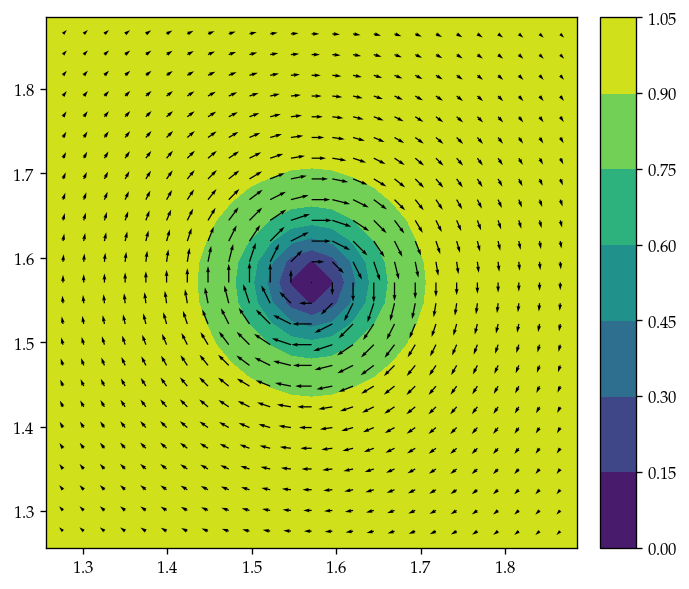

(1.2566370614359172, 1.8849555921538759)

In [9]:
fig, ax = plt.subplots(dpi=120)
figlims = (0.4pi, 0.6pi)
x, y = get_coordinates(GP_PARAMS)
ax.set_aspect(:equal)
cf = ax.contourf(x, y, rho')
# cf = ax.contourf(x, y, v[1])
fig.colorbar(cf)
ax.quiver(x, y, p[1]', p[2]', scale=12)
# ax.quiver(x, y, v[2]', v[1]', scale=15)
ax.set_xlim(figlims...)
ax.set_ylim(figlims...)

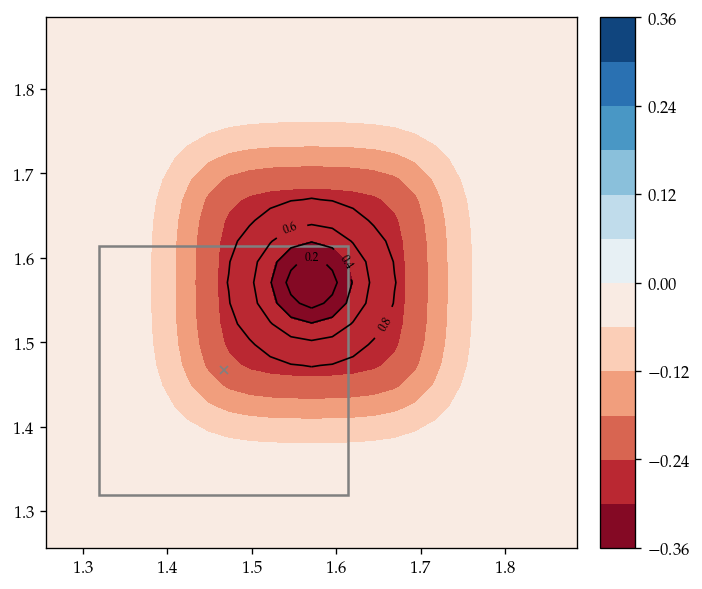

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f11cbbbfcd0>

In [10]:
fig, ax = plt.subplots(dpi=120)
ax.set_aspect(:equal)
cf = ax.contourf(x, y, circ', levels=11, cmap=plt.cm.RdBu)
# cf = ax.contourf(x, y, v[1])
fig.colorbar(cf)

# ax.quiver(x, y, p[1]', p[2]', scale=12)
# ax.quiver(x, y, v[2]', v[1]', scale=15)

ax.set_xlim(figlims...)
ax.set_ylim(figlims...)

ct = ax.contour(x, y, rho', levels=0:0.2:1, linewidths=1, colors=:black)
ax.clabel(ct, inline=true, fontsize="x-small", fmt="%.1f")

# Draw a single rectangle
kwargs = (color=:grey, lw=1.5, )
dx = GP_PARAMS.L ./ GP_PARAMS.dims
loop = Circulation.Rectangle((0, 0), loop_dims) * dx + (0.42pi, 0.42pi)
xc = Circulation.get_centre(loop)
rect = plt.matplotlib.patches.Rectangle(loop.x, loop.r...; fill=false, kwargs...)
ax.add_patch(rect)
ax.plot(xc...; marker=:x, markersize=5, kwargs...)  # rectangle centre

# VTK files (for verification)

In [11]:
using WriteVTK

@show typeof(x)

vtk_grid("fields", x, y, compress=false) do vtk
    vtk["rho"] = rho
    vtk["v"] = v
    vtk["p"] = p
    vtk["circ"] = circ
end

typeof(x) = LinRange{Float64}


1-element Array{String,1}:
 "fields.vti"

# Verify integration

In [12]:
let L = 4pi
    N = 256
    x = range(0, L, length=N + 1)[1:end-1]
    
    v = @. 0.2 + sin(x) + cos(2x)
    vI = @. 0.2x - cos(x) + sin(2x) / 2
    
    vf = rfft(v)
    k = rfftfreq(N, 2pi * N / L)
    @assert k[2] ≈ 2pi / L

    a = searchsortedlast(x, 0)
    b = searchsortedlast(x, π / 4)
    
    @show a, b
    @show x[[a, b]]
    int1 = vI[b] - vI[a]
    int2 = Circulation.integrate(vf, k, x[a], x[b]) / N
    @show int1
    @show int2
    @assert int1 ≈ int2
    @btime Circulation.integrate($vf, $k, 0.1, 0.4)
end

(a, b) = (1, 17)
x[[a, b]] = [0.0, 0.7853981633974483]
int1 = 0.9499728514929421
int2 = 0.9499728514929421
  5.777 μs (1 allocation: 16 bytes)


100.68135713980708